# Chapter 9. Modern RNN

- Topics
  - two widely used networks, GRU & LSTM, 
  - single layer => multi layer (deeper RNN)
  - unidirectional => bidirectional 
  - sequence to sequence
  - encoder-decoder

## Gated Recurrent Units (GRU)

- RNN에서의 Gradient update 관련 문제점들(explosion or vanish)이 영향 예시
  
  - sequence의 first part가 매우 중요한 역할을 한는 경우 (sequence 앞에 checksum이 있다던가...)
    - 매우 중요한 sequence의 first part를 memory cell에 저장
    - 혹은 위와 같은 memory cell이 없다면, 이 중요한 부분에 매우 큰 gradient를 할당
  
  - 혹은 반대로 어떠한 연관성도 없는 token들이 존재 (Web Content의 HTML code같이..)
    - some mechanism to skip
    
  - sequence들 간의 논리적 분리가 존재. (가령 다른 chapter로 넘어가는 부분)
    - some mechanism to reset hidden state 

- 이러한 문제점을 해소하기 위하여 다양한 방법이 제안...
  - Long Short-term memory
  - Gated recurrent unit
    - LSTM 대비 비슷한 성능 수준 / Faster compute

### Gated Hidden State

- Gating mechanism
  - hidden state의 update 혹은 reset을 결정하는 mechanism이 존재
  - 예를들어 first token이 중요하다면 first token 이후 hidden state를 update하지 않음.
  - 반대로 관련성이 낮은 token을 skip
  - 필요할 때 latent state를 reset

#### Reset Gate and Update Gate

- Reset Gate => ```얼마나 많은 이전 step의 상태를 기억할지```를 제어
- Update Gate => ```얼마나 많은 latent state가 update 되지 않고 단지 copy 될지```를 제어
- Reset gate와 update gate 제어를 위한 parameter R_t, Z_t
  - 모두 입력 X_t, H_t-1의 함수
    - R_t = sigmoid (X_t W_xr + H_t-1 W_hr + b_r)
    - Z_t = sigmoid (X_t W_xz + H_t-1 W_hz + b_z)

#### Candidate Hidden State ```H_hat_t```
- Reset parameter의 term이 고려된 Hidden state
- Update parameter는 아직 고려 안됨
- H_hat_t = tanh(X_t W_xh + elewise_prod(R_t, H_t-1) W_hh + b_h)

#### Hidden State (complete)
- H_t = elewise_prod(Z_t, H_t-1) + elewise_prod((1 - Z_t), H_hat_t)
- Z_t 가 1에 가까우면 old state를 보유
- Z_t 가 0에 가까우면 candidate hidden state를 새로운 state로 사용

### Implementation GRU from scratch


In [1]:
import torch 
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)
len(vocab)

28

In [2]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size
    
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    
    def three():
        return (normal((num_inputs, num_hiddens)), 
               normal((num_hiddens, num_hiddens)),
               torch.zeros(num_hiddens, device=device))
    
    
    W_xz, W_hz, b_z = three()
    W_xr, W_hr, b_r = three()
    W_xh, W_hh, b_h = three()
    
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params


#### Defining Model

In [3]:
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)  # '@' is matrix mul 
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)  # '*' element wise product
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda 
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

#### Training and Predicting


perplexity 1.1, 45220.1 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
traveller which are immaterial and haveno dimensions are pa


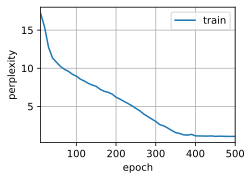

In [4]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params, init_gru_state, gru)

d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

### Concise Implementation 

perplexity 1.0, 212772.6 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


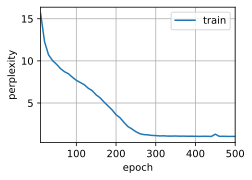

In [5]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = d2l.RNNModel(gru_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## Long Short-Term Memory (LSTM)

- Long term information preservation
- Short term input skip 
- GRU 보다 약 20년 먼저 나왔지만 LSTM이 약간 더 복잡함. 

### Gated Memory Cell

- 컴퓨터의 논리소자 logic gate를 모방
- Gates
  - ```Output gate``` : cell의 값을 다음 step의 hidden state로써 사용하게 할지 제어
  > O_t = activation ( X_t W_xo + H_t-1 W_ho + b_o)
  - ```Input gate``` : 다음 memory cell의 값이 candidate memory cell (현재 입력 X와 H에 의한 값)에 얼마나 영향을 받을지
  > I_t = activation ( X_t W_xi + H_t-1 W_hi + b_i)
  - ```Forget gate``` : 다음 memory cell의 값이 현재 memory cell의 값에 얼마나 영향을 받을지
  > F_t = activation ( X_t W_xf + H_t-1 W_hf + b_f)
- 목적은 GRU와 같음, 즉, hidden state를 유지할지 혹은 업데이트 할지 등에 대한 Mechanism을 추가한 것

#### Input Gate, Forget Gate and Output Gate

- LSTM의 입력은 현재 step 샘플과 이전 step의 hidden state
- 이들은 Input, Output, Forget gate의 control을 위한 FC layer의 입력으로도 사용됨
- 위 3 gate의 activation이 sigmoid 이므로 (0, 1) 사이의 값을 갖게됨

#### Candidate Memory Cell

- 임시적인 memory cell로 Input gate의 값에 따라 최종 memory cell에 반영될 지 결정됨
- C_hat_t = tanh( X_t W_xc + H_t-1 W_hc + b_c )
- activation이 tanh 이므로 (-1,1) 사이의 값을 갖게됨

#### Memory Cell

- C_t = elewise_prod(F_t, C_t-1) + elewise_prod(I_t, C_hat_t)
- 따라서 만약 F_t가 1에 가깝고, I_t가 0에 가깝게되면 GRU의 Skip과 비슷한 동작을 보여 long range dependencey를 반영할 수 있게됨

#### Hidden State

- H_t = elewise_prod(O_t, tanh( C_t))
- Output gate의 값에 의해 (0,1) next step의 입력으로 memory cell의 tanh 값을 hidden state로 넘길지 결정됨


### Implementation from Scratch



In [6]:
import torch 
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)


### Initializing Model Parameters
- 0.01 std.dev의 normal dist로 파라미터 초기화

In [7]:
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outpus = vocab_size
    
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    
    def three():
        return (normal((num_inputs, num_hiddens)), 
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))
    
    W_xi, W_hi, b_i = three()
    W_xf, W_hf, b_f = three()
    W_xo, W_ho, b_o = three()
    W_xc, W_hc, b_c = three()
    
    
    W_hq = normal((num_hiddens, num_outpus))
    b_q = torch.zeros(num_outpus, device=device)
    
    params = [W_xi, W_hi, b_i, 
              W_xf, W_hf, b_f,
              W_xo, W_ho, b_o, 
              W_xc, W_hc, b_c, 
              W_hq, b_q]
    
    for param in params:
        param.requires_grad_(True)
        
    return params

def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),
           torch.zeros((batch_size, num_hiddens), device=device))

def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, 
              W_xf, W_hf, b_f,
              W_xo, W_ho, b_o, 
              W_xc, W_hc, b_c, 
              W_hq, b_q] = params
    (H, C) = state
    outputs = []
    
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_hat = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I  * C_hat
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,C)
    
    

#### Training and Predict

perplexity 1.1, 39091.2 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller we can represent a figure ofa three dimensional s


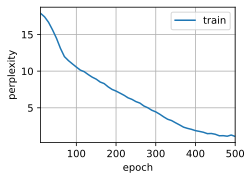

In [8]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params,
                            init_lstm_state, lstm)

d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

### Concise Implementation



perplexity 1.0, 158227.6 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


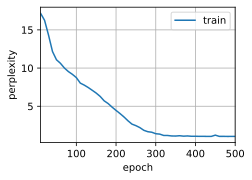

In [9]:
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)


## Deep Recurrent Neural Network

- 문장의 변화가 다양해 지면 single layer로 한계가 발생함
- linear model에서 처럼 multi layer를 적용할 수 있음
- layer 간의 데이터가 서로 연관 될 수 있는 경우 다수의 RNN을 쌓아 올릴 수 있음

### Functional Dependencies

- 기존의 feed-forward network와 달리 layer - layer의 입력으로 output이 아닌 hidden state를 전달
- 마지막 layer의 hidden state로 부터 output을 계산
- Deep RNN에서 hidden state 정보는 다음 layer의 입력으로 그리고 다음 step의 입력으로 전달된다.


In [10]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)


In [11]:

vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size

device = d2l.try_gpu()
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)


perplexity 1.0, 107339.8 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


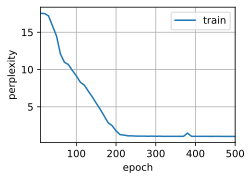

In [12]:
num_epcohs, lr = 500, 2
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## Bidirectional Recurrent Neural Networks 

- 중간에 있는 빈칸 단어 맞추기의 경우 단순 Sequential model만으로는 문장에 있는 정보를 다 활용하지 못함. (앞쪽에 있는 단어 Sequence만 입력으로 사용하므로...)
- 예를 들어 NER (Named Entity Recognition) 등 Task를 위해선 앞뒤 context에 대한 정보가 모두 중요함.
- Bidirectional Recurrent Neural Network을 통해 이런 단점을 극복할 수 있음

### Dynamic Programming in Hidden Markov Models

- 임의 값이 X_t가 latent variable h_t의 값에만 의존하는 즉, P(X_t | h_t)가 성립하는...
- 그리고 latent variable h_t는 h_t+1에 대해 어떠한 transition 확률을 갖는...
- 이러한 확률 그래프 모델을 Hidden Markov Model이라 함.
  - 앞에서 Markov Model은 임의의 X_t에 대하여 유한개의 이전 관측에 의해 일정한 확률 분포를 갖는 Model
  - Hidden Markov Model은 이전 관측이 아닌 Hidden (Latent) Variable에 일정한 확률 분포를 갖는 Model

#### H_t를 얻으려면...

- 이러한 Hidden Markov Model에서 ```X_t```를 구하기 위하여 ```H_t```를 구해야하는데...
- ```H_t```는 ```H_t-1```의 다양한 상태로 부터의 확률분포로 정의되어 있다. 만약 ```H_t-1```이 가질 수 있는 값이 (이산적으로...) K개일 경우 임의의 ```H_t```값의 확률을 얻기 위해서는 ```H_t-1```의 ```K```가지 값에 대한 확률을 모두 합하여 구할 수 있다. 
- 문제는 ```H_t-1``` 도 ```H_t-2```에 대해 ```K```가지의 확률 분포를 가지고 있어 만약 임의의 시점 ```T```에 대한 ```H_T```를 구하기 위해서는
- ```K**T``` 의 계산 복잡도를 갖는 문제가됨! **Mission Impossible**

#### Pattern Recursion & Simplicity

- 모든 Latent Variable에 대한 가능한 확률을 모두 구하는 것은 어렵지만...
- Hidden Markov Model의 Recusion Pattern을 통해 ```O(kT)```의 선형 문제로 단순화 시킬 수 있다. (Dynamic Program)
- HMM과 같은 Probabilistic Graph Model의 강점은 이와 같이 기존에 풀기 어렵던 매우 복잡한 문제를 컴퓨터로 풀 수 있는 Linear 문제로 접근할 수 있도록 해준다는 것.
- 이러한 HMM은 대상 이전과 이후의 데이터를 통해서 대상에 대한 예측성능을 끌어 올릴 수 있다.

### Bidirectional Model

- 앞서 보았던 HMM의 성능을 RNN에 적용하기 위해서 양방향 즉, forward mode와 backward mode를 조합할 수 있다.
- 이러한 Bidirectional RNN과 HMM의 차이점은 HMM의 경우 엄밀한 통계적 의미에 의해 해석될 수 있지만 Bidirectional RNN의 경우 이러한 해석이 없이 단순히 Learnable Function으로 추상화 시킨다는데 있다. 
- 즉, HMM과 Bidirectional RNN은 개념적으로 많은 유사성을 지닌다고 볼 수 있으나, HMM은 엄밀한 통계학적 해석과 증명이 가능한 반면 RNN은 그렇지 않다고 볼 수 있다.

#### Computaional Cost & Application

- 단순히 다음 Token의 예측(Causal Language Model)에 대해서는 구조적 이득을 충분히 얻기 어렵다.
- 단순 RNN 대비 매우 느리다. 
- 실질적으로 이러한 Bidirectional Layer는 몇몇 Application (NER, Translation 등)을 제외하고는 자주 사용되지는 않는다.


perplexity 1.1, 50523.5 tokens/sec on cuda:0
time travellerererererererererererererererererererererererererer
travellerererererererererererererererererererererererererer


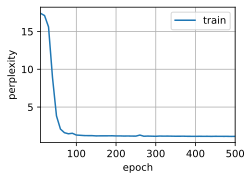

In [13]:
import torch 
from torch import nn
from d2l import torch as d2l



batch_size, num_steps , device = 32, 35, d2l.try_gpu()
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers, bidirectional=True)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)

num_epochs, lr = 500, 1
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## Machine Translation and the Dataset

- Machine Translation은 Sequence Transduction 분야에 매우 비중이 높은 영역
- Neural Network 이전에는 statistic model에 기반한 translation이 주류를 이루었으며 이를 구분하기 위해 Neural Network 기반의 translation을 Neural Machine Translation(NMT)이라고 부름
- 당연하게도 translation을 위한 dataset은 source lang.와 target lang.의 쌍으로 구성되어 있음.

In [14]:
import os
import torch
from d2l import torch as d2l

#@save
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

#@save
def read_data_nmt():
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r') as f:
        return f.read()
    
raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [15]:
#@save 
def preprocess_nmt(text):
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '
    
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


In [16]:
#@save 
def tokenize_nmt(text, num_examples=None):
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

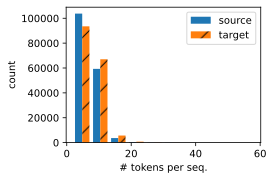

In [23]:
#@save
def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    d2l.set_figsize()
    _, _, patches = d2l.plt.hist([[len(l) for l in xlist], [len(l) for l in ylist]])
    d2l.plt.xlabel(xlabel)
    d2l.plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    d2l.plt.legend(legend)
    
show_list_len_pair_hist(['source', 'target'], '# tokens per seq.', 'count', source, target)


### Vocabulary 

- Char 기반 Tokenization 대비 Word 기반 Tokenization은 Vocab의 Size가 훨씬 크다.
- 이러한 이유로 특정 빈도 이하의 token은 ```<unk>```의 특수한 token으로 대체
- 외에 ```<pad>``` / ```<bos>``` / ```<eos>``` 등 특수 token이 사용됨.
  - pad : 각 예시의 step size를 동일하게 하기 위해서 step size 보다 짧은 seq의 뒤에 pad를 추가해 준다.
  - bos : begining of sequence로 주로 decoder에서 sequence의 생성을 시작하기 위한 token으로 사용
  - eos : end of sequence로 sequence의 termination에 해당됨
  

In [22]:
src_vocab = d2l.Vocab(source, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

### Reading the Dataset

- Language Model에서 각 sequence example을 동일한 길이(```num_steps```) 를 갖아야 함. 
- num_steps 보다 짧은 text sequence는 ```<pad>```라는 token을 추가해서 길이를 맞춤
- num_steps 보다 긴 text sequence는 truncate하여 뒤쪽을 버리는 방법으로 길이를 맞춤


In [25]:
#@save 
def truncate_pad(line, num_steps, padding_token):
    if len(line) > num_steps:
        return line[:num_steps]
    return line + [padding_token] * (num_steps - len(line))


truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [26]:
## transform sequences into minibatches for training

#@save 
def build_array_nmt(lines, vocab, num_steps):
    lines = [vocab[l] + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len



In [27]:
#@save 
def load_data_nmt(batch_size, num_steps, num_examples=600):
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab



In [29]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print(f'X: {X.type(torch.int32)} / val. len. {X_valid_len} ')
    break

X: tensor([[ 6, 73,  4,  3,  1,  1,  1,  1],
        [61,  5,  3,  1,  1,  1,  1,  1]], dtype=torch.int32) / val. len. tensor([4, 3]) 


## Encoder-Decoder Architecture

- Machine Translation 과 같은 Sequence transduction model에 사용 

- Encoder
  - Variable Length Sequence -> Fixed Length Hidden State로 변환

- Decoder
  - Fixed Length Hidden State -> Variable Length Sequence로 변환
  
### Encoder

  

In [2]:
from torch import nn

#@save 
class Encoder(nn.Module):
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        
    def forward(self, X, *args):
        raise NotImplementedError
#@save
class Decoder(nn.Module):
    
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        
    def init_state(self, enc_outputs, *args):
        raise NotImplementedError
        
    def forward(self, X, state):
        raise NotImplementedError



In [3]:
#@save
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, enc_X, dec_X, *args):
        enc_output = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_output, *args)
        return self.decoder(dec_X, dec_state)

## Seq2Seq learning

- Encoder 
  - Variable length 입력을 fixed-size hidden state로 변환
- Encoder에 의해 생성된 hidden state를 decoder에 전달
- Decoder는 위 encoder의 output과 ```<bos>``` 입력 이후 sequence를 생성하며 ```<eos>```가 출력되면 sequence가 중지

### Encoder

- Encoder에 의해 생성되는 fixed size를 context variable이라고도 함.
- 이는 결국 final layer의 hidden state를 임의의 함수에 의해 변환한 것이며 가령 가장 마지막 step의 hidden state만 취하는 것 등으로 정할 수 있음
- unidirectional RNN뿐 아니라 bidirectional RNN도 encoder로 사용 가능함.
#### Embedding layer

- Token을 Feature Vector로 변환 
- 따라서 Embedding Layer의 matrix 형태는 ```Vocab Size (Row)``` X ```Feature Vector dimension(Column)```


In [4]:
from torch import nn
import torch
from d2l import torch as d2l

#@save
class Seq2SeqEncoder(d2l.Encoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, 
                 num_layers, dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout)
        
    def forward(self, X, *args):
        X = self.embedding(X)
        X = X.permute(1, 0, 2)
        output, state = self.rnn(X)
        return output, state

encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape, state.shape
        

(torch.Size([7, 4, 16]), torch.Size([2, 4, 16]))

### Decoder

- Encoder의 출력인 Context Variable은 입력 Seq. 전체를 Encode한 결과물
- 최종 Output Seq. 는 각 Step에 대해 그 이전 Step의 Output Seq. 그리고 Context Variable의 조건부 확률로 볼 수 있다. 이를 모델링 한 것이 Decoder
- 이러한 상관 관계를 Learnable function g를 이용해 표현하면 
  - S_t = g(y_t-1, C, S_t-1) 
- y_t = f(S_t, y_t-1) 


In [5]:
from torch import nn
import torch
from d2l import torch as d2l

class Seq2SeqDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(*kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
        
    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]
    
    def forward(self, X, state):
        X = self.embedding(X).permute(1, 0, 2)
        
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1,0,2)
        return output, state
    
    
        

In [6]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)

decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

### Loss Function

- Output Token에 대한 Cross Entropy
- 단, Padding 이나 EOS 등의 특수 Token은 Cross Entropy 계산 시 포함되지 않도록 해야 함 (실제보다 더 낮은 Loss를 띄게되므로...)


In [7]:
#@save 
def sequence_mask(X: torch.Tensor, valid_len, value=0):
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None, :] < valid_len[:,None]
    X[~mask] = value
    return X

X = torch.tensor([[1,2,3], [4,5,6]])
sequence_mask(X, torch.tensor([1,2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [8]:
#@save 
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    
    def forward(self, pred, label, valid_len):
     #   print(f' {pred.shape} / {label.shape}')
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction = 'none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(pred.permute(0,2,1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss
    
    

In [9]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3,4,10), torch.ones((3,4), dtype=torch.long), torch.tensor([4,2,0]))

tensor([2.3026, 1.1513, 0.0000])

### Training


In [10]:
#@save 
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weights" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[10, num_epochs])
    
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0], device=device).reshape(-1, 1)
            
            dec_input = torch.cat([bos, Y[:, :-1]], 1) 
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1], ))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')
    
        

loss 0.019, 13500.1 tokens/sec on cuda:0


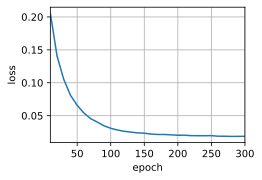

In [11]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

### Prediction

- ```<bos>```를 초기 Step의 입력으로 줌으로써 Sequence를 예측.
- ```<eos>```가 출력되면 prediction이 완결된 것으로 처리


In [12]:
#@save 
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps, 
                    device, save_attention_weights=False):
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)] , device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    
    enc_X = torch.unsqueeze(torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq
    
    

### Evaluation on Predicted Sequence

- Label Seq.와 Pred Seq를 비교 
- Machine Translation의 평가를 위해 도입된 BLEU, 현재는 보다 광범위한 Seq2Seq용 평가 지표로 사용됨
- 각 n-grams에 대해 label의 sequence와 pred seq.를 비교, n이 클 수록 점수 가중치를 적용



In [15]:
import math
import collections

def bleu(pred_seq, label_seq, k):
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i:i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i:i + n])] -= 1
            score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score
            
    

In [17]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va , maintenant ., bleu 0.000
i lost . => j'ai perdu ., bleu 0.396
he's calm . => il est <unk> ., bleu 0.095
i'm home . => je suis chez prie ., bleu 0.064


## Beam Search

- output seq.의 예측시 eos라는 특별한 token이 예측될 때까지 예측을 반복
- output seq.를 예측하는 것은 주어진 조건에서 에서 가장 높은 화률을 갖는 값을 output seq.를 찾는 것 (탐색의 문제)

### Greedy Search

- 앞서 예시의 경우 각 step에서 최대 조건부 확률 값을 갖는 token을 선택하는 형태로 **greedy search**
- 따라서 조건부 확률의 seq. 예측 시 sub optimal의 가능성이 존재


### Exhaustive Search

- 비현실적인 복잡도를 가짐 

### Beam Search

- 매 step Top K개를 선택 
- exponential 하게 K개씩 선택하는 것이 아니라 각 Step에서 총 K개, 즉, 결국 K개의 Seq.가 최종적으로 출력됨
- 이는 Exhaustive Search와 Greedy Search의 절충. 



